In [1]:
%matplotlib inline
# %matplotlib qt
import hyperspy.api as hs
import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
import matplotlib
from snmfem.models import edxs
import json
import snmfem.spectrum_fitting as sf
from snmfem.estimators import NMF

# Guide to this notebook

Every time the symbol ⚠️ appears, a user input is required in the cell below.

If a cell made a few windows pop up, please kill the windows once you're done. Otherwise every new plot will be displayed in top of the other (which may slow your computer down). 

Overview of the different steps :
- I. Load the data either a spectrum (go to step III.) or a spectrum image
- II. Select an area of interest in your spectrum image.
- III. Creates an energy scale (x) from your data for the fitting procedure.
- IV. Selects the regions of the spectrum were there are no peaks for background fitting.
- V. Creates the required objects (partial x and y) for the background fitting procedure.
- VI. Fitting the background. If this is not satisfactory go back to IV.

# I. Load data

Either a spectrum or a full spim

## Load spectrum
⚠️

In [2]:
spectrum = hs.load("46_ES-LP_L6_brg_test2.spx").isig[0.20 : 19.9]

⚠️ It is easier to fit the background on average spectra than on sum spectra. In pix_number, put the number of spectra you integrated.

In [3]:
pix_number = 43400
spectrum.data = spectrum.data /pix_number

## Load spectrum image

## .bcf file

⚠️

In [ ]:
haadf,spim = hs.load("46_ES-LP_L6_brg.bcf")

## .emd file

⚠️ Be careful, depending on the number of elemental map or spectra you saved in your emd file you may need to inspect the output of ``hs.load``.
Simply put ``hs.load(file)`` in a new cell locate the haadf and the spim.

In [ ]:
s, haadf, map, spim = hs.load("1119 SI EDS-HAADF.emd")

# II. Select an area of interest

⚠️ 3 windows will pop up. 
- One window correspond to a 2D representation of the spim (sum along the energy direction) a green rectangle will be displayed on top of it, it corresponds to the selected area. 
- One window correspond to the first pixel (top left) of the spectrum image (you can ignore it). 
- The last window correspond to the average of the selected spectra

In [ ]:
    haadf_ROI=hs.roi.RectangularROI(10*spim.axes_manager[0].scale,
                                10*spim.axes_manager[1].scale,
                                40*spim.axes_manager[0].scale,
                                40*spim.axes_manager[1].scale)
    # arguments = left, top, right, bottom in pixels*scale
    spim.plot()
    spim_ROI=haadf_ROI.interactive(spim)
    # The HAADF and SPIM windows with their respective ROIs. The two ROIs are connected so that the selected area in the HAADF is the same as the one on the SPIM.
    
    spectrum=hs.interactive(spim_ROI.mean,
               event=spim_ROI.axes_manager.events.any_axis_changed,
               recompute_out_event=None)
    spectrum.plot(True)

# III. Calibrate x

In [4]:
offset = spectrum.axes_manager[0].offset
scale = spectrum.axes_manager[0].scale
size = spectrum.axes_manager[0].size

x = np.linspace(offset,size*scale+offset,num = size)

# IV. Select areas for bckgd fitting

⚠️ Input in the ``span_number`` the number of selection areas you wish to use. Once you execute the cell, a window will pop with a few green areas and a red spectrum. The green areas correspond to the regions were the background will be fitted. You can, drag, enlarge and reduce these green areas.

In [ ]:
span_number = 5

def selection_areas(number,spectrum,scale) :
    spectrum.plot()
    roi_list = []
    for i in range(number) :
        roi_list.append(hs.roi.SpanROI(i+20*scale,i+40*scale))
        roi_list[-1].interactive(spectrum)
    return roi_list

spans = selection_areas(span_number,spectrum,scale)

In [ ]:
list_energies = [[roi.left,roi.right] for roi in spans]

⚠️ Execute this cell only if you want to use a previous selection of areas for the background fitting.

In [5]:
list_energies = [[0.8014116348999999, 0.8514658053999999], [1.3820400126999997, 1.4020616808999997], [1.9526575563999997, 1.9826900586999998], [2.4231667590999995, 2.5332859341999994], [3.3241418280999997, 3.5243585101], [4.2651602335, 4.965918620499999], [6.6477387493, 6.8479554313], [11.8333508131, 14.9867635546]]

# VI. Fitting the continuum

In [6]:
part_x, part_y, sum_boola = sf.make_partial_xy(list_energies,spectrum,x)

example = {"params_dict" : {"b0" : 1.0, "b1" : -1.0, "b2" : 0.5, "Det" : "SDD_efficiency.txt"}, "thickness" : 100e-7, "elements_dict" : {
    "Cu" : 0.06,
    "Zn" : 0.06,
    "Ga" : 0.06,
    "Zr" : 0.06,
    "Pt" : 0.06,
    "Pb" : 0.06,
    "Mg" : 0.06,
    "Al" : 0.06,
    "Si" : 0.06,
    "Ca" : 0.06,
    "Fe" : 0.06,
    "U" : 0.06,
    "Lu" : 0.06,
    "Hf" : 0.06,
    "Sm" : 0.06
    }}

pars = sf.ndict_to_params(example)

out = lm.minimize(sf.residual, pars, args=(part_x,), kws={'data': part_y})
print(lm.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 446
    # variables        = 4
    chi-square         = 3.5951e-04
    reduced chi-square = 8.1338e-07
    Akaike info crit   = -6249.85963
    Bayesian info crit = -6233.45835
[[Variables]]
    params_dict__b0:    0.05492349 +/- 0.00237086 (4.32%) (init = 1)
    params_dict__b1:   -0.00863961 +/- 7.0852e-04 (8.20%) (init = -1)
    params_dict__b2:    4.4682e-04 +/- 4.1077e-05 (9.19%) (init = 0.5)
    thickness:          6.4820e-06 +/- 8.2448e-07 (12.72%) (init = 1e-05)
    elements_dict__Cu:  0.06 (fixed)
    elements_dict__Zn:  0.06 (fixed)
    elements_dict__Ga:  0.06 (fixed)
    elements_dict__Zr:  0.06 (fixed)
    elements_dict__Pt:  0.06 (fixed)
    elements_dict__Pb:  0.06 (fixed)
    elements_dict__Mg:  0.06 (fixed)
    elements_dict__Al:  0.06 (fixed)
    elements_dict__Si:  0.06 (fixed)
    elements_dict__Ca:  0.06 (fixed)
    elements_dict__Fe:  0.06 (fixed)
    elements_

### Plotting the results

The red curves corresponds to the background model, the black one to the data, and the grey area correspond to the selected green areas

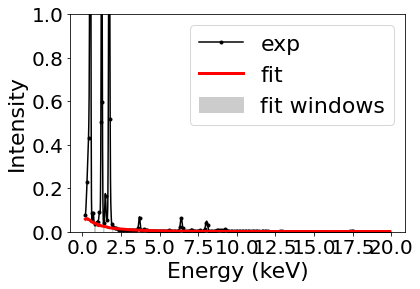

In [9]:
y = spectrum.data
bkgd = sf.residual(out.params,x)
plt.plot(x,y,"ko-",markersize=3,label="exp",markevery=10)
plt.fill_between(x,0,y,where=sum_boola,label="fit windows",color="0.8")
plt.xlabel("Energy (keV)",fontsize=22)
plt.xticks(fontsize=20)
plt.ylim(0,1)
plt.yticks(fontsize=20)
plt.ylabel("Intensity",fontsize=22)
plt.plot(x,bkgd,"r-",linewidth=3,label="fit")
plt.legend(fontsize=22)

# VII. Select the interesting part of the spectrum

⚠️ A window will pop up with a red spectrum and a green area. With the green areas, you can select the energy range you want to quantify. Usually the low energy region (below 1keV) is not very well fitted by the background model. Hence you probably want to avoid the quantification of low energy characteristic X rays. 

If you feel brave enough you can uncomment some parts of the background modelling part and achieve a better background fit at low energies. At your own risks.

In [10]:
s_bkgd = hs.signals.Signal1D(bkgd)
s_bkgd.axes_manager[0].offset = offset
s_bkgd.axes_manager[0].scale = scale

spectrum.plot()
ax = spectrum._plot.signal_plot.ax
ax.add_line(matplotlib.lines.Line2D(spectrum._plot.axis.axis,bkgd.data))
roi = hs.roi.SpanROI(20*scale,40*scale)
roi.interactive(spectrum)

<EDSTEMSpectrum, title: EDX, dimensions: (|20)>

AttributeError: 'FigureCanvasSVG' object has no attribute 'copy_from_bbox'

### Accepting the choice of quantification energy range

In [ ]:
charac_xrays = (spectrum.isig[roi.left:roi.right].data - s_bkgd.isig[roi.left:roi.right].data).clip(min=0)
new_offset = spectrum.isig[roi.left:roi.right].axes_manager[0].offset
new_size = spectrum.isig[roi.left:roi.right].axes_manager[0].size

# VIII. Fitting the characteristic Xrays

### Initialisation of the characteristic Xray model
⚠️ Put the list of elements (by atomic numbers) you want to quantify in ``elt_list``. 

``G_calib`` is a small offset you may want to add so that the peaks are at the right energy. 

Note that depending on the energy range you chose, not all the elements you put are fitted (e.g. Oxygen will not be taken into account if your energy range starts at 1 keV)

In [ ]:
elt_list = [29,30,31,40,78,81,12,13,14,20,26,92,71,72,60,62]
G_calib = -0.005

In [ ]:
db = "default_xrays.json"

true_elt_list = []
for elt in elt_list : 
    mod_t = edxs.EDXS(new_offset,new_size,scale,{},db_name = db,energy_range = [new_offset,new_size*scale+new_offset])
    mod_t.generate_g_matr([elt],norm=False)
    G_t = mod_t.G
    if G_t.shape[1] == 1 : 
        true_elt_list.append(elt)
    
mod = edxs.EDXS(new_offset + G_calib,new_size,scale,{},db_name = db,energy_range = [new_offset,new_size*scale+new_offset])
mod.generate_g_matr(true_elt_list,norm=False)
G = mod.G
new_x = np.linspace(new_offset,new_size*scale+new_offset,num = new_size)
print("List of elements with Xray lines in the energy range :")
print(true_elt_list)

### Fitting the characteristic Xrays

In [ ]:
estimator = NMF(n_components= 1,max_iter=2000,force_simplex = True,tol = 1e-8)
estimator.fit_transform(G=G, A=np.array([1])[:,np.newaxis], X=charac_xrays[:,np.newaxis])
P = estimator.P_

⚠️ If you want to fix the values of P you obtained in a previous fit put them in ``fixed_elts`` and execute the two following cells. 

For a two steps quantification : Chose a first energy range. Perform a first fit, which initialise P with all the elements. Then go back to the energy range selection, ignore the cell above, chose the fixed elements and perform the fit with fixed elements below. 

In [ ]:
fixed_elts = [71,72]

In [ ]:
inds = [true_elt_list.index(elt) for elt in fix_elts]
trunc_elt_list = [v for i,v in enumerate(true_elt_list) if i not in frozenset(inds)] 
trunc_G = np.delete(G, inds, axis=1)
fixed_P = P[inds]
fixed_G = G[:,inds]
estimator = NMF(n_components= 1,max_iter=2000,force_simplex = True,tol = 1e-8)
estimator.fit_transform(G=trunc_G, A=np.array([1])[:,np.newaxis], X=charac_xrays[:,np.newaxis])
trunc_P = estimator.P_
P = np.concatenate((trunc_P,fixed_P))
G = np.hstack((trunc_G,fixed_G))
true_elt_list = trunc_elt_list + fixed_elts

# IX. Plot the results

⚠️ The popping window will display the bkgd substracted experimental spectrum, the fitted characteristic Xrays model in black and red. Every element composing the model will be displayed with an offset : ``components_offset``. You can change its value below. 

If you want to display the names of the lines of an element that was used for quantification execute the next cells below before kill the window.

In [ ]:
components_offset = -0.1

In [ ]:
linestyles = [":","--","-."]

plt.plot(new_x,charac_xrays,"ko-",label="exp",markevery = 10)
plt.plot(new_x,G@P,"r",linewidth = 3,label="theo")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("energy (keV)",fontsize = 18)
plt.ylabel("Intensity", fontsize = 18)

for i in range(G.shape[1]) :
    ls_string = linestyles[i%len(linestyles)] + "C{}".format(i%9)
    plt.plot(new_x,G[:,i]*P[i]+components_offset,ls_string,label=str(true_elt_list[i]),linewidth=3)


plt.legend(fontsize=18)
plt.tight_layout()

⚠️ You can change the `select_elt` to display the lines of this element. (It is probably going to messy as a lot of lines have very close energy). Execute this cell if you want to identify some lines.  

In [ ]:
select_elt = "72"

In [ ]:
with open("xray_lines.json","r") as f :
    lines_dict = json.load(f)["table"]    

for line in lines_dict[select_elt].keys() :
    if (lines_dict[select_elt][line]["energy"]> new_offset) and (lines_dict[select_elt][line]["energy"]<new_size*scale+new_offset) :
        plt.text(lines_dict[select_elt][line]["energy"],0.0,line,fontsize=18)


# X. Printing the concentrations

Full summary of normalized concentrations.

In [ ]:
r = P/P.sum(axis=0)
for i in range(P.shape[0]) :
    print("Z : ",true_elt_list[i],"  rel conc : ",r[i])

⚠️ You can remove some elements of the results, normalizing on the remaining elements.

In [ ]:
ignored_elts = [29,30]

In [ ]:
inds = [true_elt_list.index(elt) for elt in ignored_elts]
remain_elt_list = [v for i,v in enumerate(true_elt_list) if i not in frozenset(inds)] 
remain_P = np.delete(P, inds, axis=0)
r = remain_P / remain_P.sum(axis=0)
for i in range(r.shape[0]) :
    print("Z : ",remain_elt_list[i],"  rel conc : ",r[i])